# NDIndex Slicing Gallery

This notebook provides visual examples of how NDIndex slicing works using images.
By wrapping an image in an xarray DataArray with 2D coordinates, we can see
exactly what regions are selected by different slice operations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import cbook

from linked_indices import NDIndex

## Setup: Load an image and create 2D coordinates

We'll use matplotlib's sample image and create a 2D coordinate system where
the coordinate values vary non-uniformly across the image.

Image shape: (600, 512)


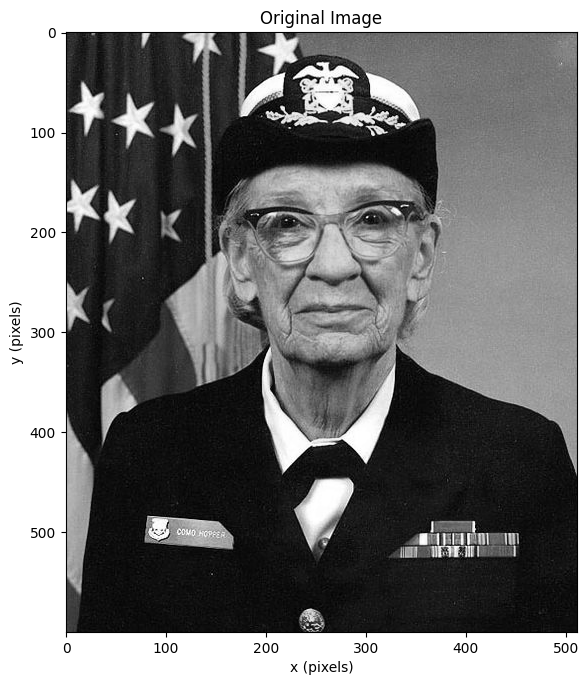

In [2]:
# Load matplotlib sample image
with cbook.get_sample_data("grace_hopper.jpg") as image_file:
    image = plt.imread(image_file)

# Convert to grayscale for simpler visualization
gray = np.mean(image, axis=2)
print(f"Image shape: {gray.shape}")

fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(gray, cmap="gray")
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_title("Original Image")
plt.tight_layout()

## Create a 2D coordinate with a gradient

Let's create a 2D coordinate that increases diagonally across the image.
This simulates a derived coordinate like `abs_time = trial_offset + rel_time`.

In [3]:
ny, nx = gray.shape

# Create 1D coordinates
y_coord = np.arange(ny)
x_coord = np.arange(nx)

# Create a 2D "derived" coordinate: diagonal gradient
# Each row has values offset by the row index
# This is like: derived[y, x] = y_offset[y] + x_coord[x]
y_offset = y_coord * 2  # Each row starts 2 units higher
derived_coord = y_offset[:, np.newaxis] + x_coord[np.newaxis, :]

print(f"Derived coord shape: {derived_coord.shape}")
print(f"Derived coord range: {derived_coord.min():.0f} to {derived_coord.max():.0f}")

Derived coord shape: (600, 512)
Derived coord range: 0 to 1709


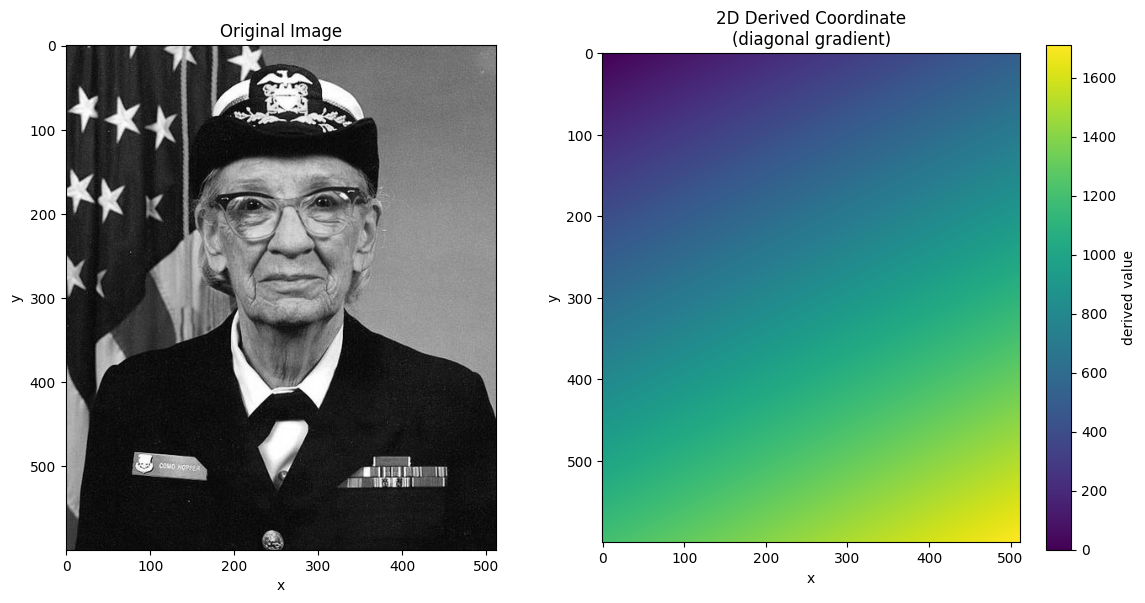

In [4]:
# Visualize the derived coordinate
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.imshow(gray, cmap="gray")
ax.set_title("Original Image")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[1]
im = ax.imshow(derived_coord, cmap="viridis")
ax.set_title("2D Derived Coordinate\n(diagonal gradient)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax, label="derived value")

plt.tight_layout()

## Create xarray DataArray with NDIndex

Now we wrap the image in an xarray DataArray and attach the 2D coordinate with NDIndex.

In [5]:
# Create DataArray
da = xr.DataArray(
    gray,
    dims=["y", "x"],
    coords={
        "y": y_coord,
        "x": x_coord,
        "derived": (["y", "x"], derived_coord),
    },
    name="image",
)

# Apply NDIndex to the 2D derived coordinate
da_indexed = da.set_xindex(["derived"], NDIndex)
da_indexed

<xarray.DataArray 'image' (y: 600, x: 512)> Size: 2MB
array([[ 40.66666667,  47.33333333,  53.33333333, ..., 126.33333333,
        121.33333333, 126.33333333],
       [ 45.66666667,  45.33333333,  47.33333333, ..., 110.33333333,
        106.33333333, 112.33333333],
       [ 40.66666667,  40.33333333,  40.33333333, ..., 128.66666667,
        129.66666667, 137.66666667],
       ...,
       [ 63.66666667,  70.33333333,  70.33333333, ...,  15.33333333,
         14.33333333,  12.33333333],
       [ 61.33333333,  65.33333333,  67.        , ...,  14.33333333,
         14.33333333,  13.33333333],
       [ 62.33333333,  64.33333333,  65.66666667, ...,  15.33333333,
         15.33333333,  15.33333333]], shape=(600, 512))
Coordinates:
  * y        (y) int64 5kB 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
  * x        (x) int64 4kB 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511
  * derived  (y, x) int64 2MB 0 1 2 3 4 5 6 ... 1704 1705 1706 1707 1708 1709
Indexes:
    derived  NDIndex

## Scalar Selection

Selecting a single value finds the cell closest to that value in the 2D coordinate.

In [6]:
# Select the cell where derived is closest to 500
result = da_indexed.sel(derived=500, method="nearest")
print(f"Selected point: y={result.y.item()}, x={result.x.item()}")
print(f"Derived value at that point: {result.derived.item():.1f}")

Selected point: y=0, x=500
Derived value at that point: 500.0


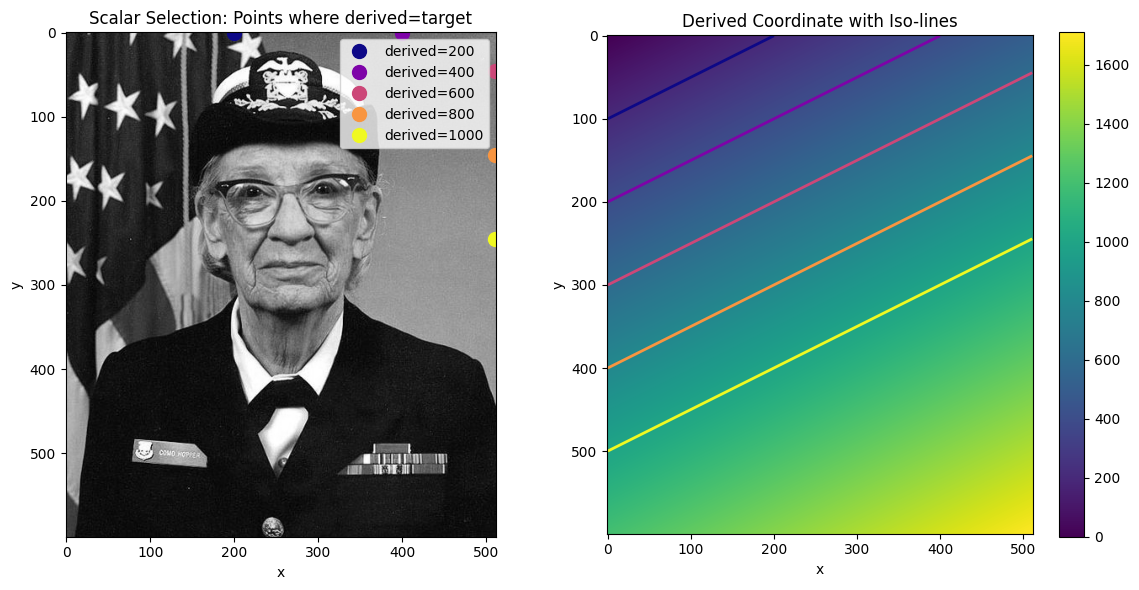

In [7]:
# Visualize scalar selections at different values
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show image with selected points
ax = axes[0]
ax.imshow(gray, cmap="gray")

targets = [200, 400, 600, 800, 1000]
colors = plt.cm.plasma(np.linspace(0, 1, len(targets)))

for target, color in zip(targets, colors):
    result = da_indexed.sel(derived=target, method="nearest")
    ax.plot(
        result.x.item(),
        result.y.item(),
        "o",
        color=color,
        markersize=10,
        label=f"derived={target}",
    )

ax.legend(loc="upper right")
ax.set_title("Scalar Selection: Points where derived=target")
ax.set_xlabel("x")
ax.set_ylabel("y")

# Show derived coordinate with iso-lines
ax = axes[1]
im = ax.imshow(derived_coord, cmap="viridis")
# Draw contours for each target value with matching colors
for target, color in zip(targets, colors):
    ax.contour(derived_coord, levels=[target], colors=[color], linewidths=2)
ax.set_title("Derived Coordinate with Iso-lines")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax)

plt.tight_layout()

## Slice Selection: Bounding Box Behavior

When you select a range with `slice()`, NDIndex returns a **bounding box** - the smallest
rectangular region containing all cells with values in that range.

This is important: the bounding box may include cells **outside** your requested range!

In [8]:
# Select range: derived between 400 and 600
start, stop = 400, 600
result = da_indexed.sel(derived=slice(start, stop))

print(f"Requested: derived in [{start}, {stop}]")
print(f"Result shape: {result.shape}")
print(f"Result y range: {result.y.values[0]} to {result.y.values[-1]}")
print(f"Result x range: {result.x.values[0]} to {result.x.values[-1]}")
print(
    f"Derived values in result: {result.derived.values.min():.0f} to {result.derived.values.max():.0f}"
)

Requested: derived in [400, 600]
Result shape: (301, 512)
Result y range: 0 to 300
Result x range: 0 to 511
Derived values in result: 0 to 1111


In [9]:
def visualize_slice_selection(da_indexed, start, stop):
    """Visualize a slice selection showing the bounding box behavior."""
    result = da_indexed.sel(derived=slice(start, stop))

    # Get the bounding box coordinates
    y_min, y_max = result.y.values[0], result.y.values[-1]
    x_min, x_max = result.x.values[0], result.x.values[-1]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original with bounding box
    ax = axes[0]
    ax.imshow(da_indexed.values, cmap="gray")
    # Draw bounding box
    rect = plt.Rectangle(
        (x_min - 0.5, y_min - 0.5),
        x_max - x_min + 1,
        y_max - y_min + 1,
        fill=False,
        edgecolor="red",
        linewidth=3,
    )
    ax.add_patch(rect)
    ax.set_title(f"Original with Bounding Box\nderived in [{start}, {stop}]")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Derived coordinate with mask
    ax = axes[1]
    derived = da_indexed.derived.values
    in_range = (derived >= start) & (derived <= stop)

    # Show derived with in-range cells highlighted
    ax.imshow(derived, cmap="viridis", alpha=0.5)
    ax.imshow(np.where(in_range, 1, np.nan), cmap="Reds", alpha=0.7, vmin=0, vmax=1)
    rect = plt.Rectangle(
        (x_min - 0.5, y_min - 0.5),
        x_max - x_min + 1,
        y_max - y_min + 1,
        fill=False,
        edgecolor="red",
        linewidth=3,
    )
    ax.add_patch(rect)
    ax.set_title("Cells in range (red) vs bounding box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Result
    ax = axes[2]
    ax.imshow(result.values, cmap="gray")
    ax.set_title(f"Result: {result.shape}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    plt.tight_layout()
    return fig

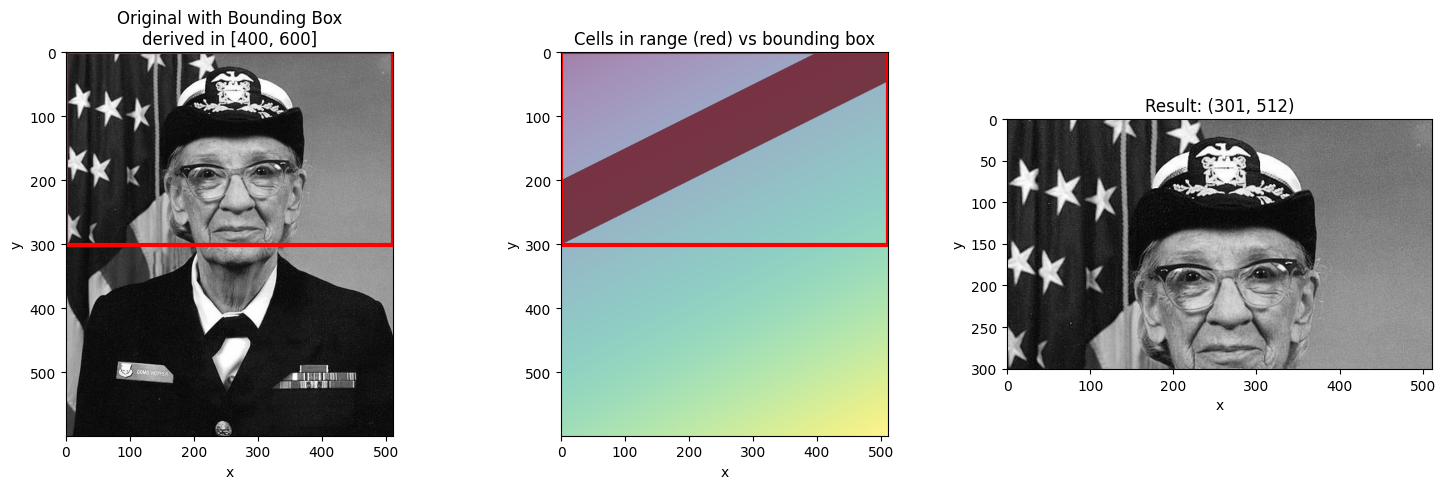

In [10]:
visualize_slice_selection(da_indexed, 400, 600);

## Different Slice Ranges

Let's see how different ranges produce different bounding boxes.

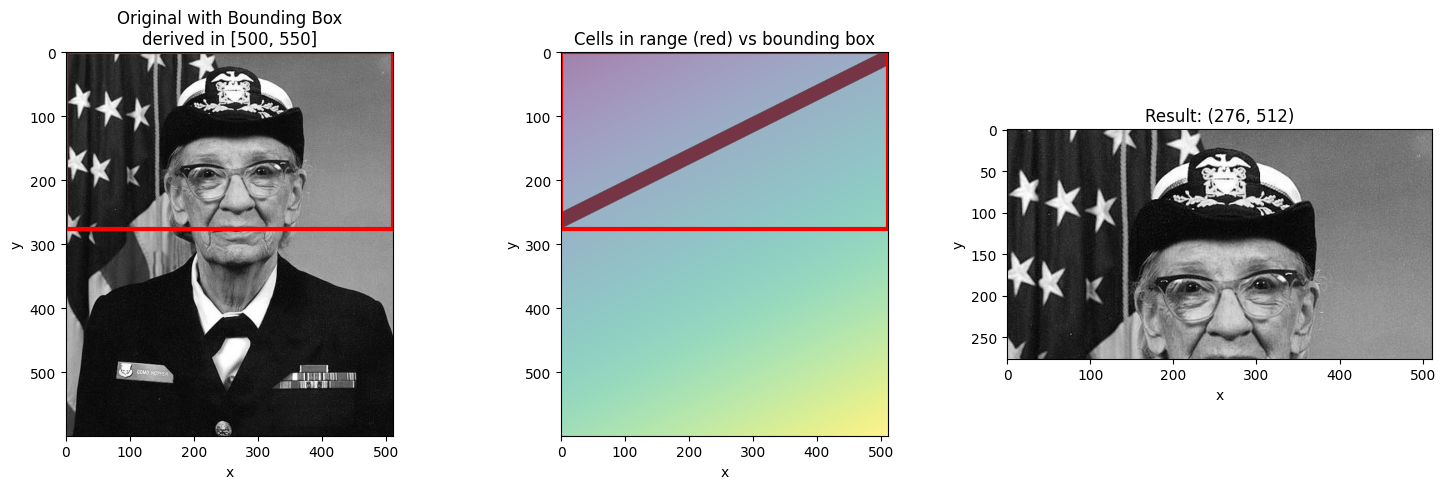

In [11]:
# Narrow range - smaller bounding box
visualize_slice_selection(da_indexed, 500, 550);

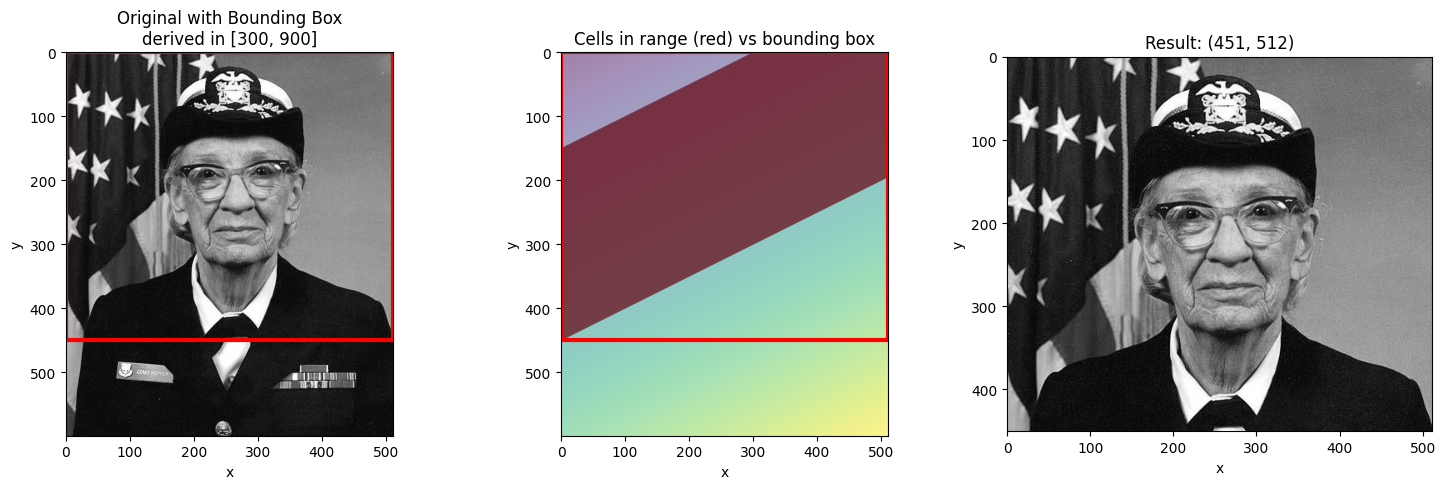

In [12]:
# Wide range - larger bounding box
visualize_slice_selection(da_indexed, 300, 900);

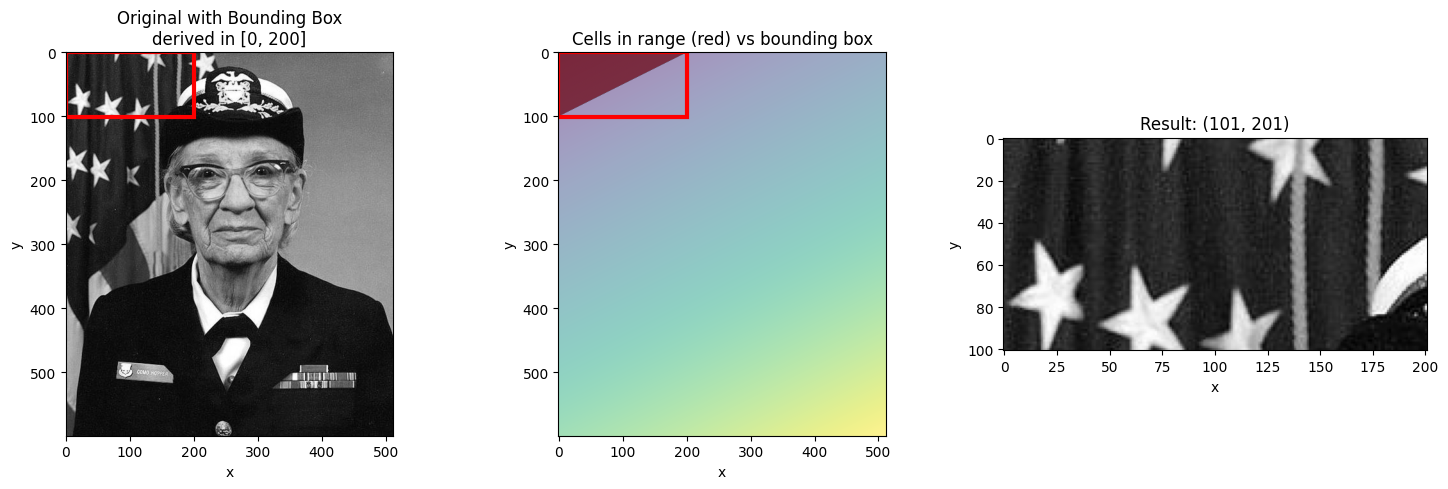

In [13]:
# Range at the edge
visualize_slice_selection(da_indexed, 0, 200);

## Filtering with `.where()` after Selection

Since the bounding box includes cells outside your requested range, you may want to
filter the result using `.where()` to mask out values not in the range.

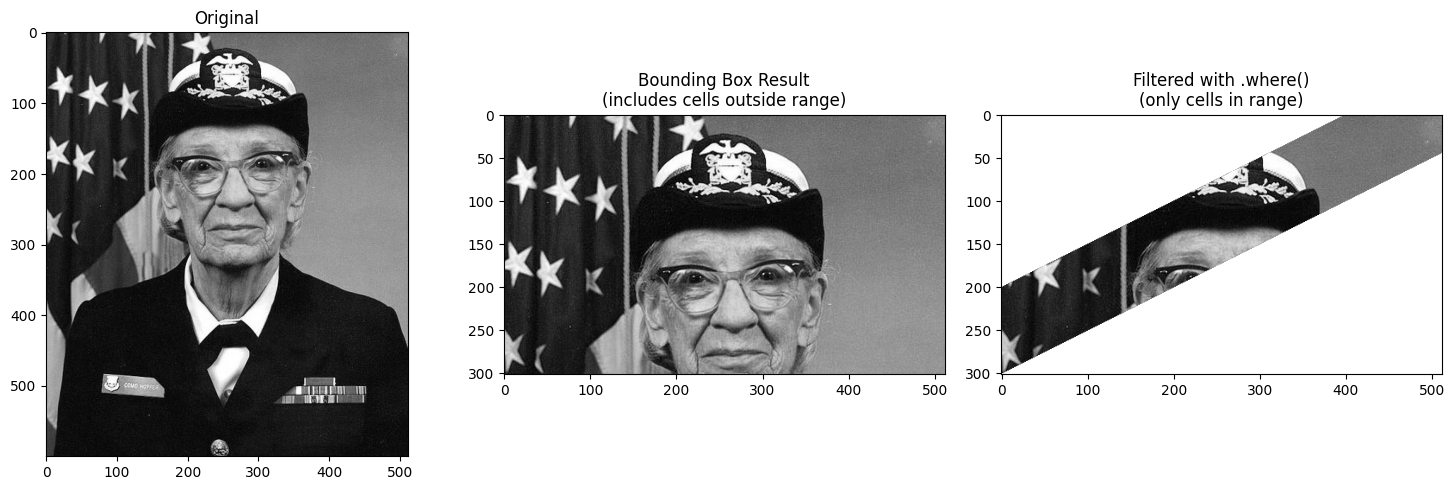

In [14]:
start, stop = 400, 600
result = da_indexed.sel(derived=slice(start, stop))

# Filter to only show cells actually in range
in_range = (result.derived >= start) & (result.derived <= stop)
filtered = result.where(in_range)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.imshow(da_indexed.values, cmap="gray")
ax.set_title("Original")

ax = axes[1]
ax.imshow(result.values, cmap="gray")
ax.set_title("Bounding Box Result\n(includes cells outside range)")

ax = axes[2]
ax.imshow(filtered.values, cmap="gray")
ax.set_title("Filtered with .where()\n(only cells in range)")

plt.tight_layout()

## Using Step in Slices

You can include a step in the slice to subsample the innermost dimension.

In [15]:
start, stop = 400, 800

# Without step
result_no_step = da_indexed.sel(derived=slice(start, stop))

# With step=10 (subsample every 10th pixel in x)
result_with_step = da_indexed.sel(derived=slice(start, stop, 10))

print(f"Without step: {result_no_step.shape}")
print(f"With step=10: {result_with_step.shape}")

Without step: (401, 512)
With step=10: (401, 52)


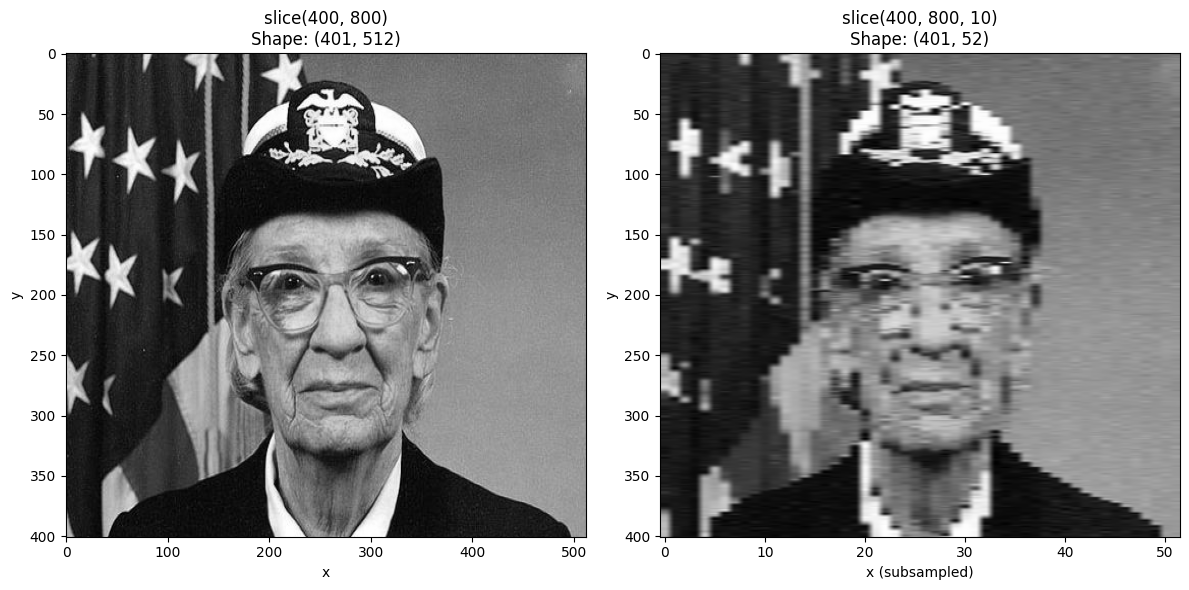

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.imshow(result_no_step.values, cmap="gray", aspect="auto")
ax.set_title(f"slice({start}, {stop})\nShape: {result_no_step.shape}")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[1]
ax.imshow(result_with_step.values, cmap="gray", aspect="auto")
ax.set_title(f"slice({start}, {stop}, 10)\nShape: {result_with_step.shape}")
ax.set_xlabel("x (subsampled)")
ax.set_ylabel("y")

plt.tight_layout()

## Non-Linear 2D Coordinates

The bounding box behavior becomes more interesting with non-linear coordinates.
Let's create a radial coordinate to see how this works.

In [17]:
# Create a radial coordinate centered on the image
cy, cx = ny // 2, nx // 2  # center
yy, xx = np.meshgrid(np.arange(ny) - cy, np.arange(nx) - cx, indexing="ij")
radial_coord = np.sqrt(xx**2 + yy**2)

# Create DataArray with radial coordinate
da_radial = xr.DataArray(
    gray,
    dims=["y", "x"],
    coords={
        "y": y_coord,
        "x": x_coord,
        "radius": (["y", "x"], radial_coord),
    },
    name="image",
)
da_radial_indexed = da_radial.set_xindex(["radius"], NDIndex)

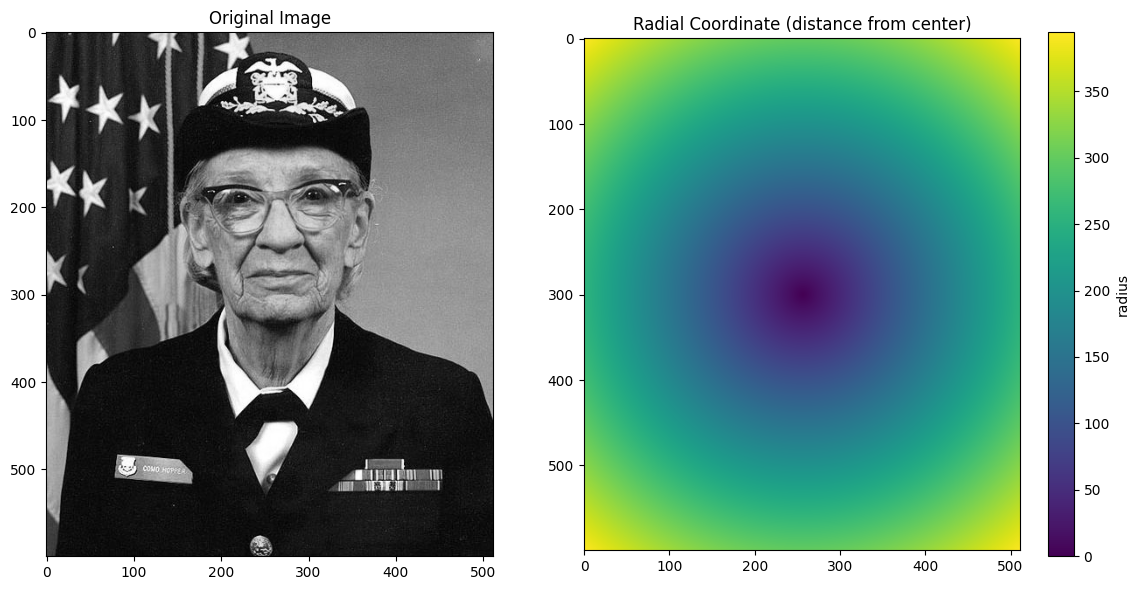

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.imshow(gray, cmap="gray")
ax.set_title("Original Image")

ax = axes[1]
im = ax.imshow(radial_coord, cmap="viridis")
ax.set_title("Radial Coordinate (distance from center)")
plt.colorbar(im, ax=ax, label="radius")

plt.tight_layout()

In [19]:
def visualize_radial_selection(da_indexed, start, stop):
    """Visualize selection on radial coordinate."""
    result = da_indexed.sel(radius=slice(start, stop))

    y_min, y_max = result.y.values[0], result.y.values[-1]
    x_min, x_max = result.x.values[0], result.x.values[-1]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax = axes[0]
    ax.imshow(da_indexed.values, cmap="gray")
    rect = plt.Rectangle(
        (x_min - 0.5, y_min - 0.5),
        x_max - x_min + 1,
        y_max - y_min + 1,
        fill=False,
        edgecolor="red",
        linewidth=3,
    )
    ax.add_patch(rect)
    ax.set_title(f"Bounding box for radius in [{start}, {stop}]")

    ax = axes[1]
    radius = da_indexed.radius.values
    in_range = (radius >= start) & (radius <= stop)
    ax.imshow(np.where(in_range, gray, gray * 0.3), cmap="gray")
    ax.set_title(f"Cells with radius in [{start}, {stop}]")

    ax = axes[2]
    ax.imshow(result.values, cmap="gray")
    ax.set_title(f"Result (bounding box): {result.shape}")

    plt.tight_layout()
    return fig

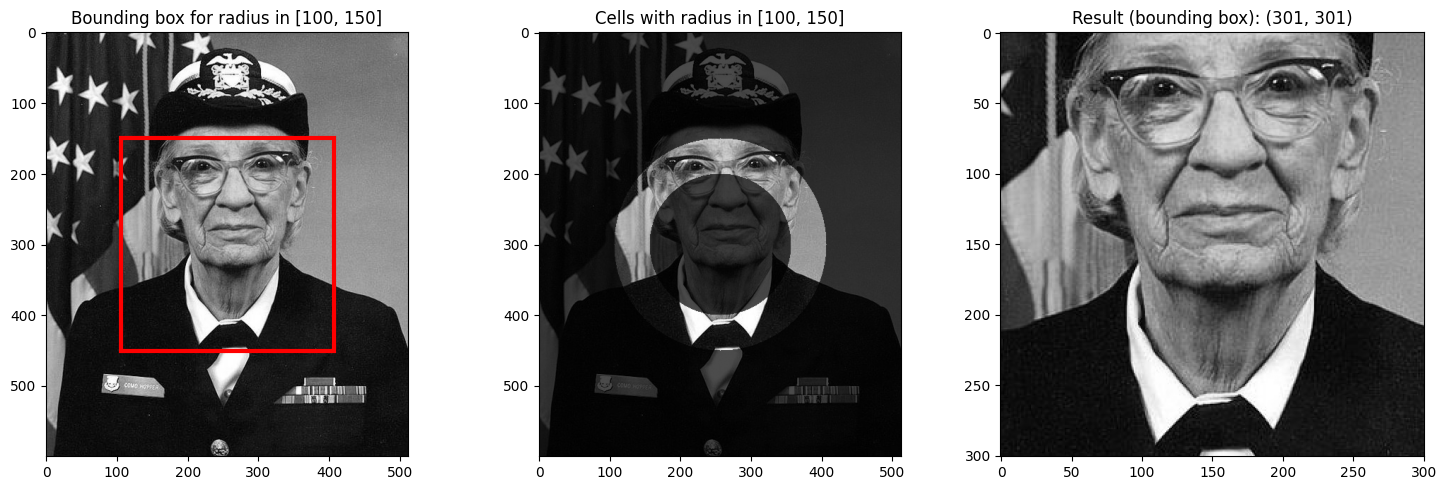

In [20]:
# Select an annulus (ring) - see how bounding box captures the whole ring
visualize_radial_selection(da_radial_indexed, 100, 150);

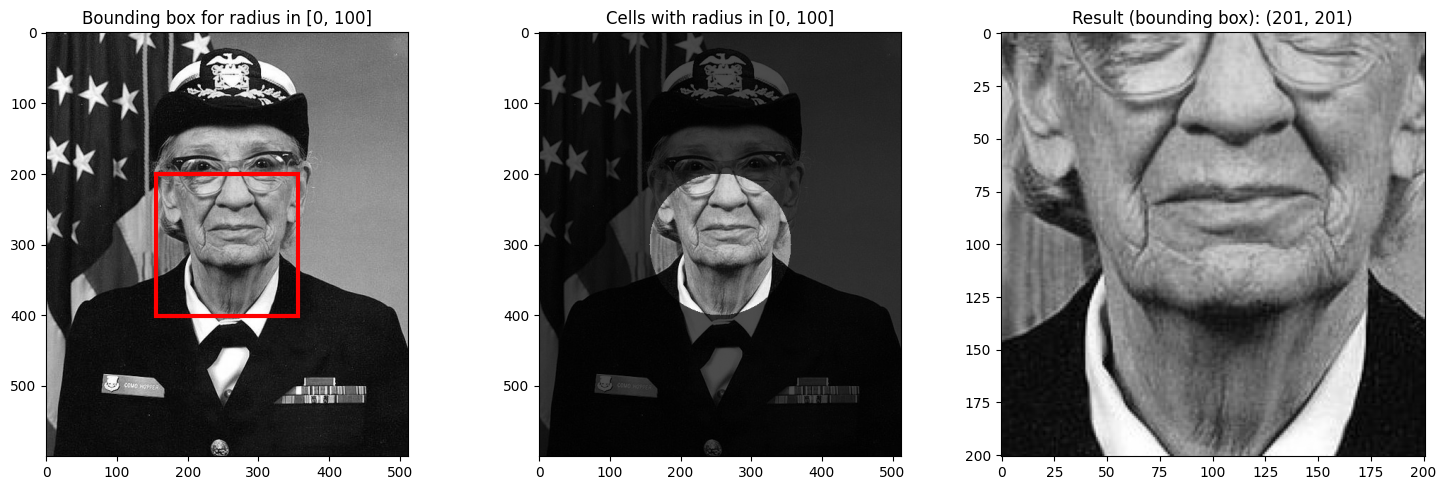

In [21]:
# Select center region
visualize_radial_selection(da_radial_indexed, 0, 100);

Notice how the bounding box for an annulus (ring) includes the entire rectangular region
around the ring, even though only the ring itself has radius values in the requested range.

This is the key insight about NDIndex's bounding box behavior: it returns the smallest
**rectangular** region that contains all matching cells, which may include non-matching cells.

## Summary: Bounding Box Behavior

Key points about NDIndex slicing with standard `ds.sel()`:

1. **Scalar selection** finds the single cell closest to the target value
2. **Slice selection** returns a **bounding box** containing all cells in range
3. The bounding box may include cells **outside** your requested range
4. Use `.where()` after selection to mask out values not in range
5. Use `slice(start, stop, step)` to subsample the innermost dimension

---

## Non-Rectangular Selection with `nd_sel`

The standard `ds.sel()` always returns a rectangular bounding box. But sometimes you want
**only** the cells actually in your requested range, with everything else masked out.

### Why a Helper Function?

xarray's custom index protocol (`Index.sel()`) returns an `IndexSelResult` which contains
indexers for each dimension. These can be slices, integer arrays, or boolean arrays.
While `IndexSelResult` *can* express non-rectangular selections via boolean arrays, it cannot:

- **Apply masks to data values** (setting cells to NaN while preserving the array shape)
- **Add new coordinates** (like a boolean membership indicator)

The index tells xarray *which indices* to select, but it doesn't have access to the actual
data values to modify them. That's why we need a helper function that:
1. First calls `ds.sel()` to get the bounding box (fast, O(log n))
2. Then applies the mask or adds the metadata coordinate as a post-processing step

### The `returns` Parameter

The `nd_sel` helper function provides non-rectangular selection with the `returns` parameter:

| Mode | Behavior | Creates Copy? |
|------|----------|---------------|
| `returns='slice'` | Standard bounding box (same as `ds.sel()`) | No (view) |
| `returns='mask'` | Bounding box with NaN outside the range | Yes (via `.where()`) |
| `returns='metadata'` | Bounding box + boolean coordinate showing membership | No (view) |

In [22]:
from linked_indices import nd_sel

# Compare the three return modes
start, stop = 400, 600

# Standard slice (bounding box)
result_slice = nd_sel(da_indexed, derived=slice(start, stop), returns="slice")

# Mask mode: NaN outside range
result_mask = nd_sel(da_indexed, derived=slice(start, stop), returns="mask")

# Metadata mode: boolean coordinate added
result_meta = nd_sel(da_indexed, derived=slice(start, stop), returns="metadata")

print(f"All three have same shape: {result_slice.shape}")
print(
    f"Metadata mode adds coordinate: 'in_derived_range' = {result_meta.coords['in_derived_range'].dtype}"
)

All three have same shape: (301, 512)
Metadata mode adds coordinate: 'in_derived_range' = bool


### Visual Comparison: `returns='slice'` vs `returns='mask'`

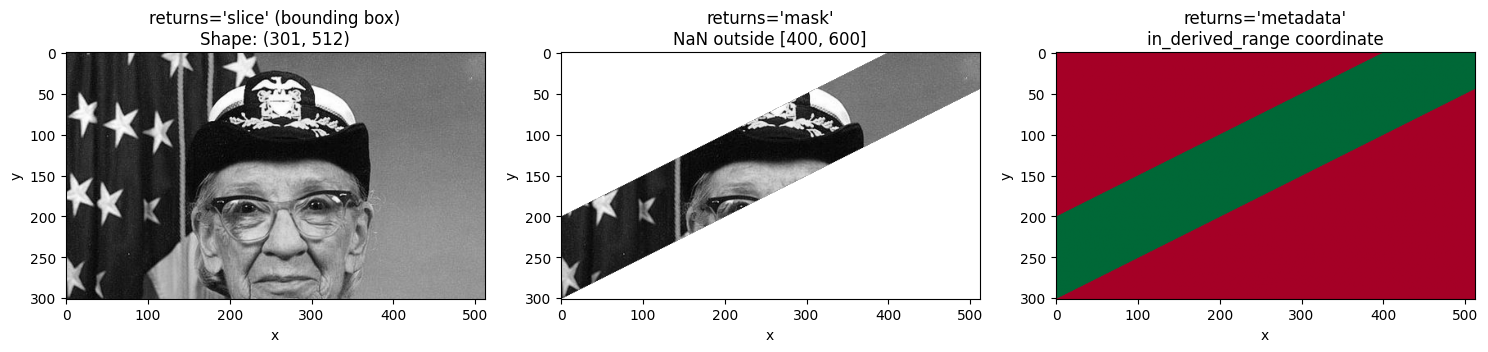

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.imshow(result_slice.values, cmap="gray")
ax.set_title(f"returns='slice' (bounding box)\nShape: {result_slice.shape}")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[1]
ax.imshow(result_mask.values, cmap="gray")
ax.set_title(f"returns='mask'\nNaN outside [{start}, {stop}]")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[2]
# Show the metadata boolean coordinate
ax.imshow(result_meta.coords["in_derived_range"].values, cmap="RdYlGn", vmin=0, vmax=1)
ax.set_title("returns='metadata'\nin_derived_range coordinate")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.tight_layout()

### Radial Selection with Masking

The mask mode is especially useful with non-linear coordinates like radial distance.
With bounding box selection, an annulus (ring) returns a rectangle. With masking, 
you get just the ring.

In [24]:
# Select a ring (annulus) with different return modes
r_start, r_stop = 100, 150

# Bounding box (standard)
ring_slice = nd_sel(da_radial_indexed, radius=slice(r_start, r_stop), returns="slice")

# Masked - only the ring, rest is NaN
ring_mask = nd_sel(da_radial_indexed, radius=slice(r_start, r_stop), returns="mask")

print(f"Both have same shape: {ring_slice.shape}")
print(
    f"But mask has {np.isnan(ring_mask.values).sum():,} NaN values out of {ring_mask.size:,} total"
)

Both have same shape: (301, 301)
But mask has 51,317 NaN values out of 90,601 total


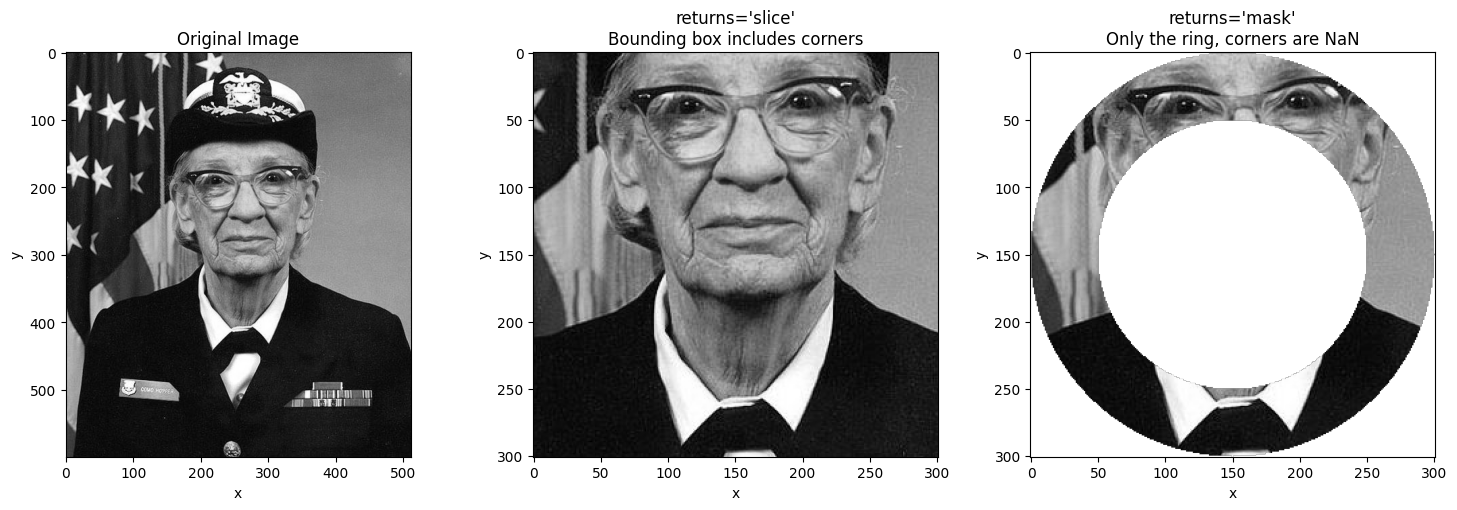

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.imshow(da_radial_indexed.values, cmap="gray")
ax.set_title("Original Image")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[1]
ax.imshow(ring_slice.values, cmap="gray")
ax.set_title("returns='slice'\nBounding box includes corners")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[2]
ax.imshow(ring_mask.values, cmap="gray")
ax.set_title("returns='mask'\nOnly the ring, corners are NaN")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.tight_layout()

### Combining with `method='nearest'`

You can combine `returns='mask'` with `method='nearest'` to snap boundaries to the 
nearest existing values before applying the mask.

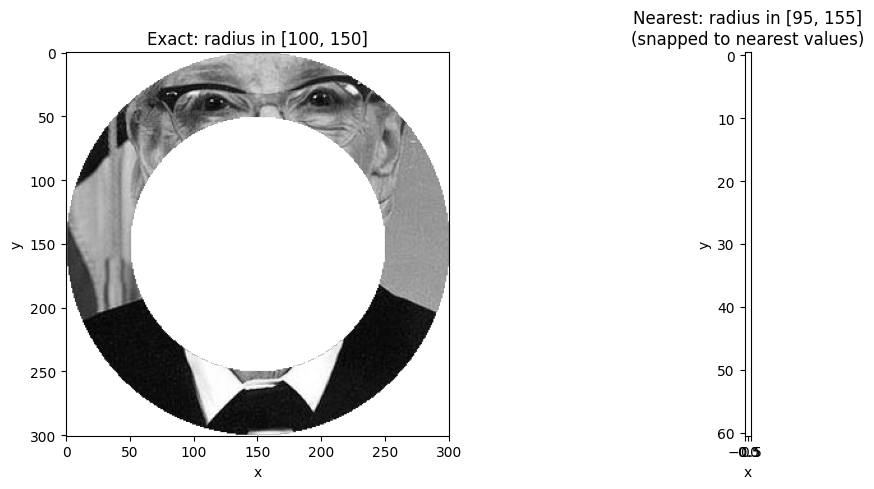

In [26]:
# Use nearest to snap boundaries
# Request radius 95-155, which snaps to nearest actual values
ring_nearest = nd_sel(
    da_radial_indexed,
    radius=slice(95, 155),  # Not exact values in the coordinate
    method="nearest",
    returns="mask",
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.imshow(ring_mask.values, cmap="gray")
ax.set_title("Exact: radius in [100, 150]")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = axes[1]
ax.imshow(ring_nearest.values, cmap="gray")
ax.set_title("Nearest: radius in [95, 155]\n(snapped to nearest values)")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.tight_layout()

### Using the Boolean Coordinate from `returns='metadata'`

The `returns='metadata'` mode adds a boolean coordinate that you can use for
custom filtering, statistics, or visualization.

In [27]:
# Get result with membership metadata
result_with_meta = nd_sel(da_radial_indexed, radius=slice(100, 150), returns="metadata")

print("Coordinates in result:")
for name, coord in result_with_meta.coords.items():
    print(f"  {name}: {coord.dims}, dtype={coord.dtype}")

# Use the boolean coordinate for statistics
in_ring = result_with_meta.coords["in_radius_range"]
print(f"\nPixels in ring: {in_ring.sum().item():,}")
print(f"Mean value in ring: {result_with_meta.where(in_ring).mean().item():.1f}")
print(f"Mean value outside ring: {result_with_meta.where(~in_ring).mean().item():.1f}")

Coordinates in result:
  y: ('y',), dtype=int64
  x: ('x',), dtype=int64
  radius: ('y', 'x'), dtype=float64
  in_radius_range: ('y', 'x'), dtype=bool

Pixels in ring: 39,284
Mean value in ring: 105.6
Mean value outside ring: 100.6


## Summary

The `nd_sel` helper function extends NDIndex selection with three return modes:

```python
from linked_indices import nd_sel

# Standard bounding box (same as ds.sel())
result = nd_sel(ds, coord=slice(start, stop), returns='slice')

# Mask values outside range with NaN
result = nd_sel(ds, coord=slice(start, stop), returns='mask')

# Add boolean coordinate for custom processing
result = nd_sel(ds, coord=slice(start, stop), returns='metadata')
```

Key points:
- All modes first compute the O(log n) bounding box, then apply post-processing
- `returns='mask'` creates a copy (via `.where()`)
- `returns='metadata'` preserves views, just adds a coordinate
- Combine with `method='nearest'` to snap boundaries to nearest values
- The helper is needed because xarray's `IndexSelResult` cannot apply masks to data values